## Libraries

In [1]:
!pip install datasets torch torchvision scikit-learn pandas matplotlib seaborn tqdm h5py

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/84/57/2f64161769610cf6b1c5ed782bd8a780e18a3c9d48931319f2887fa9d0b1/torch-2.8.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/93/40/3415d890eb357b25a8e0a215d32365a88ecc75a283f75c4e919024b22d97/torchvision-0.23.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.10.0 from https://files.pythonhosted.org/packages/18/67/36e9267722cc04a6b9f15c7f3441c2363321a3ea07da7ae0c0707beb2a9c/typing_extensions-4.15.0-py3-none-any.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:-

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.


In [2]:
import numpy as np
from datasets import load_dataset
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import os

## Data Preprocessing

Saving to .h5 file from hugging-face

In [3]:
# Load a subset of the dataset to test (e.g., first 10,000 samples)
ds = load_dataset("solarbench/SKIPPD", split='train').select(range(10000))  # Limit to 10,000 samples

# Extract PV and times (small, load fully)
pv = np.array(ds['pv'])  # Shape: (num_samples,)
times = ds['time']  # List for reference

# Preload and normalize images (subset to avoid memory issues)
images = np.array([np.array(img['image']) for img in ds], dtype=np.float32) / 255.0  # Shape: (num_samples, 64, 64, 3)

# Normalize PV to [0, 1]
scaler = MinMaxScaler()
pv_normalized = scaler.fit_transform(pv.reshape(-1, 1)).squeeze()

# Save to HDF5 file (including images for faster access)
save_path = 'skippd_dataset_subset.h5'
with h5py.File(save_path, 'w') as f:
    f.create_dataset('pv_normalized', data=pv_normalized)
    f.create_dataset('times', data=np.array(times, dtype='S'))  # Save as bytes strings
    f.create_dataset('images', data=images)  # Save preloaded images

print(f"Dataset subset saved to {save_path}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/439M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/349372 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14003 [00:00<?, ? examples/s]

Dataset subset saved to skippd_dataset_subset.h5



--- Sequence 1 ---


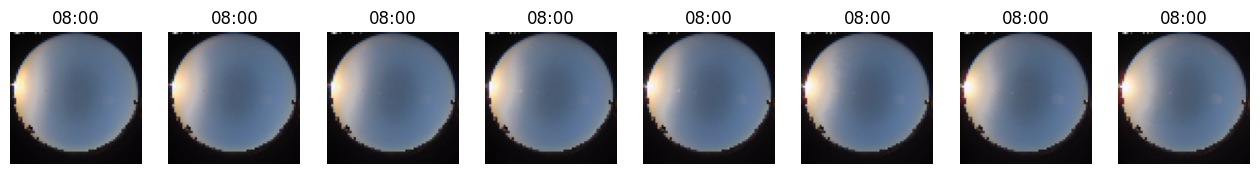

                     Time  PV (normalized)
2017-03-09 06:47:00-08:00         0.001942
2017-03-09 06:48:00-08:00         0.003105
2017-03-09 06:49:00-08:00         0.003823
2017-03-09 06:50:00-08:00         0.004317
2017-03-09 06:51:00-08:00         0.005603
2017-03-09 06:52:00-08:00         0.006581
2017-03-09 06:53:00-08:00         0.008663
2017-03-09 06:54:00-08:00         0.010735
Target PV (t+15): 0.0126 at 2017-03-09 06:56:00-08:00

--- Sequence 2 ---


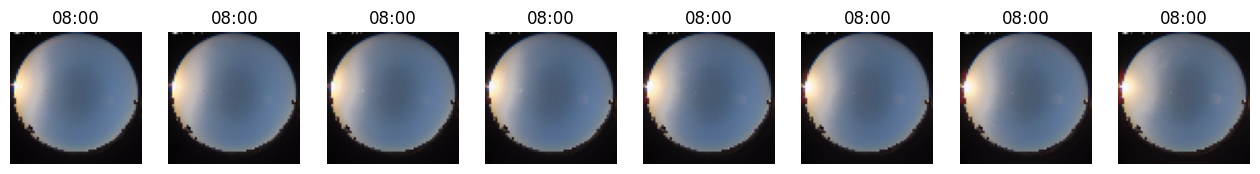

                     Time  PV (normalized)
2017-03-09 06:48:00-08:00         0.003105
2017-03-09 06:49:00-08:00         0.003823
2017-03-09 06:50:00-08:00         0.004317
2017-03-09 06:51:00-08:00         0.005603
2017-03-09 06:52:00-08:00         0.006581
2017-03-09 06:53:00-08:00         0.008663
2017-03-09 06:54:00-08:00         0.010735
2017-03-09 06:55:00-08:00         0.013257
Target PV (t+15): 0.0121 at 2017-03-09 06:57:00-08:00

--- Sequence 3 ---


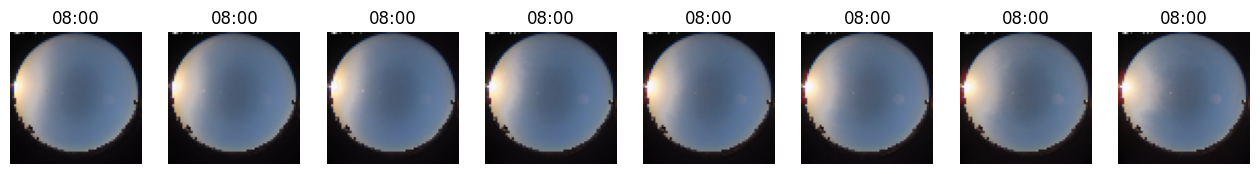

                     Time  PV (normalized)
2017-03-09 06:49:00-08:00         0.003823
2017-03-09 06:50:00-08:00         0.004317
2017-03-09 06:51:00-08:00         0.005603
2017-03-09 06:52:00-08:00         0.006581
2017-03-09 06:53:00-08:00         0.008663
2017-03-09 06:54:00-08:00         0.010735
2017-03-09 06:55:00-08:00         0.013257
2017-03-09 06:56:00-08:00         0.012631
Target PV (t+15): 0.0125 at 2017-03-09 06:58:00-08:00


In [4]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load saved subset
with h5py.File('skippd_dataset_subset.h5', 'r') as f:
    pv_norm = f['pv_normalized'][:]
    times = f['times'][:].astype(str)
    images = f['images'][:]

# Parameters
seq_len = 8   # past 15 min at 2-min intervals
horizon = 15  # prediction horizon in minutes
num_samples_to_show = 3

for idx in range(num_samples_to_show):
    start = idx
    end = idx + seq_len
    target = idx + seq_len + 1   # target PV at t+15

    if target >= len(pv_norm):
        break

    print(f"\n--- Sequence {idx+1} ---")

    # Plot the image sequence
    fig, axes = plt.subplots(1, seq_len, figsize=(16, 3))
    for t in range(seq_len):
        axes[t].imshow(images[start + t])
        axes[t].axis("off")
        axes[t].set_title(f"{times[start + t][-5:]}")  # show last part of timestamp
    plt.show()

    # PV history table
    df = pd.DataFrame({
        "Time": times[start:end],
        "PV (normalized)": pv_norm[start:end]
    })
    print(df.to_string(index=False))

    print(f"Target PV (t+{horizon}): {pv_norm[target]:.4f} at {times[target]}")


Sample cell below , optional

In [ ]:
import h5py
import os
import pandas as pd
from PIL import Image

# Load saved dataset
with h5py.File("skippd_dataset_subset.h5", "r") as f:
    pv_norm = f["pv_normalized"][:]
    times = f["times"][:].astype(str)
    images = f["images"][:]

# Unnormalize PV values (true values)
pv_true = scaler.inverse_transform(pv_norm.reshape(-1, 1)).flatten()

# Parameters
seq_len = 8
num_samples_to_save = 5
output_dir = "saved_sequences"
excel_path = "saved_sequences.xlsx"

os.makedirs(output_dir, exist_ok=True)

# Collect rows for Excel
records = []

for idx in range(num_samples_to_save):
    start = idx
    end = idx + seq_len

    if end >= len(pv_true):
        break

    seq_folder = os.path.join(output_dir, f"sequence_{idx+1}")
    os.makedirs(seq_folder, exist_ok=True)

    # Save images
    for t in range(seq_len):
        img = Image.fromarray((images[start + t] * 255).astype("uint8"))
        img_filename = f"seq{idx+1}_step{t+1}_{times[start+t].replace(':','-')}.png"
        img_path = os.path.join(seq_folder, img_filename)
        img.save(img_path)

        # Append record for Excel (only input PV history)
        records.append({
            "Sequence": idx+1,
            "Step": t+1,
            "Time": times[start+t],
            "True PV": pv_true[start+t],
            "Image File": img_filename
        })

# Save to Excel
df = pd.DataFrame(records)
df.to_excel(excel_path, index=False)

print(f"✅ Saved {num_samples_to_save} sequences into '{output_dir}'")
print(f"✅ Metadata with TRUE PV history saved to '{excel_path}'")


: 

## Model

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch
import h5py
from sklearn.model_selection import train_test_split

class SolarDataset(Dataset):
    def __init__(self, h5_file, indices, history_length=15, pred_horizon=15):
        self.h5_file = h5py.File(h5_file, 'r')
        self.pv_normalized = self.h5_file['pv_normalized']
        self.times = self.h5_file['times']
        self.images = self.h5_file['images']
        self.indices = indices
        self.history_length = history_length
        self.pred_horizon = pred_horizon
        self.num_samples = len(self.pv_normalized)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_idx = self.indices[idx]

        # Load image sequence from preloaded HDF5
        images = self.images[start_idx:start_idx + self.history_length]  # Shape: (history_length, 64, 64, 3)
        images = torch.tensor(images.transpose(0, 3, 1, 2), dtype=torch.float32)  # (time, C, H, W)

        # Past PV sequence
        past_pv = self.pv_normalized[start_idx:start_idx + self.history_length]
        past_pv = torch.tensor(past_pv, dtype=torch.float32).unsqueeze(-1)  # (time, 1)

        # Target: PV at t + history + pred_horizon - 1 (for t+15)
        target = self.pv_normalized[start_idx + self.history_length + self.pred_horizon - 1]
        target = torch.tensor(target, dtype=torch.float32)

        return images, past_pv, target

    def __del__(self):
        self.h5_file.close()

# Create sequence indices
history_length = 15
pred_horizon = 15
num_samples = len(pv)
start_indices = [i for i in range(num_samples - history_length - pred_horizon + 1) if i + history_length + pred_horizon - 1 < num_samples]
train_indices, test_indices = train_test_split(start_indices, test_size=0.2, random_state=42)

# Create datasets
train_dataset = SolarDataset('skippd_dataset_subset.h5', train_indices)
test_dataset = SolarDataset('skippd_dataset_subset.h5', test_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"Training sequences: {len(train_indices)}, Test sequences: {len(test_indices)}")

Training sequences: 7976, Test sequences: 1995


In [7]:
class SunsetForecast(nn.Module):
    def __init__(self, history_length=15):
        super(SunsetForecast, self).__init__()
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 128)
        self.lstm = nn.LSTM(input_size=128 + 1, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, images, past_pv):
        batch_size, seq_len, C, H, W = images.size()
        cnn_features = []
        for t in range(seq_len):
            feat = self.cnn(images[:, t, :, :, :])
            cnn_features.append(feat)
        cnn_features = torch.stack(cnn_features, dim=1)
        inputs = torch.cat((cnn_features, past_pv), dim=2)
        lstm_out, _ = self.lstm(inputs)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out.squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SunsetForecast().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


## Training

In [8]:
epochs = 10
train_losses = []
val_losses = []

%matplotlib inline

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for img_seq, pv_seq, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        img_seq, pv_seq, target = img_seq.to(device), pv_seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(img_seq, pv_seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img_seq, pv_seq, target in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} Validation"):
            img_seq, pv_seq, target = img_seq.to(device), pv_seq.to(device), target.to(device)
            output = model(img_seq, pv_seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Validation Loss: {avg_val_loss:.4f}\n")

Epoch 1/10: 100%|██████████| 499/499 [01:56<00:00,  4.30it/s]


Epoch 1/10, Average Training Loss: 0.0101


Epoch 1/10 Validation: 100%|██████████| 125/125 [00:08<00:00, 14.62it/s]


Epoch 1/10, Average Validation Loss: 0.0071



Epoch 2/10: 100%|██████████| 499/499 [01:49<00:00,  4.54it/s]


Epoch 2/10, Average Training Loss: 0.0048


Epoch 2/10 Validation: 100%|██████████| 125/125 [00:08<00:00, 14.81it/s]


Epoch 2/10, Average Validation Loss: 0.0073



Epoch 3/10: 100%|██████████| 499/499 [01:50<00:00,  4.53it/s]


Epoch 3/10, Average Training Loss: 0.0041


Epoch 3/10 Validation: 100%|██████████| 125/125 [00:08<00:00, 15.14it/s]


Epoch 3/10, Average Validation Loss: 0.0069



Epoch 4/10: 100%|██████████| 499/499 [01:49<00:00,  4.54it/s]


Epoch 4/10, Average Training Loss: 0.0052


Epoch 4/10 Validation: 100%|██████████| 125/125 [00:08<00:00, 15.03it/s]


Epoch 4/10, Average Validation Loss: 0.0088



Epoch 5/10: 100%|██████████| 499/499 [01:49<00:00,  4.55it/s]


Epoch 5/10, Average Training Loss: 0.0051


Epoch 5/10 Validation: 100%|██████████| 125/125 [00:08<00:00, 14.71it/s]


Epoch 5/10, Average Validation Loss: 0.0073



Epoch 6/10: 100%|██████████| 499/499 [01:50<00:00,  4.53it/s]


Epoch 6/10, Average Training Loss: 0.0032


Epoch 6/10 Validation: 100%|██████████| 125/125 [00:08<00:00, 14.68it/s]


Epoch 6/10, Average Validation Loss: 0.0073



Epoch 7/10: 100%|██████████| 499/499 [01:50<00:00,  4.52it/s]


Epoch 7/10, Average Training Loss: 0.0030


Epoch 7/10 Validation: 100%|██████████| 125/125 [00:08<00:00, 14.77it/s]


Epoch 7/10, Average Validation Loss: 0.0033



Epoch 8/10: 100%|██████████| 499/499 [01:50<00:00,  4.53it/s]


Epoch 8/10, Average Training Loss: 0.0030


Epoch 8/10 Validation: 100%|██████████| 125/125 [00:08<00:00, 14.94it/s]


Epoch 8/10, Average Validation Loss: 0.0042



Epoch 9/10: 100%|██████████| 499/499 [01:50<00:00,  4.53it/s]


Epoch 9/10, Average Training Loss: 0.0028


Epoch 9/10 Validation: 100%|██████████| 125/125 [00:08<00:00, 15.09it/s]


Epoch 9/10, Average Validation Loss: 0.0040



Epoch 10/10: 100%|██████████| 499/499 [01:50<00:00,  4.53it/s]


Epoch 10/10, Average Training Loss: 0.0021


Epoch 10/10 Validation: 100%|██████████| 125/125 [00:08<00:00, 14.98it/s]

Epoch 10/10, Average Validation Loss: 0.0023



In [9]:
import torch
import joblib

# Paths
model_path = "saved_model.pth"
scaler_path = "scaler.pkl"
losses_path = "losses.npz"

# Save trained model
torch.save(model.state_dict(), model_path)

# Save scaler (if used)
joblib.dump(scaler, scaler_path)

# Save losses for later visualization
np.savez(losses_path, train_losses=train_losses, val_losses=val_losses)

print(f"✅ Model saved to {model_path}")
print(f"✅ Scaler saved to {scaler_path}")
print(f"✅ Losses saved to {losses_path}")

✅ Model saved to saved_model.pth
✅ Scaler saved to scaler.pkl
✅ Losses saved to losses.npz


## Validation

In [14]:
from sklearn.preprocessing import MinMaxScaler
import joblib
# Load scaler if saved, or refit if not
try:
    scaler = joblib.load('scaler.pkl')
    print("Loaded from pkl file")  # Save in Cell 3 with joblib.dump(scaler, 'scaler.pkl')
except FileNotFoundError:
    scaler = MinMaxScaler()
    scaler.fit(pv.reshape(-1, 1))  # Refit if original data is available

Loaded from pkl file


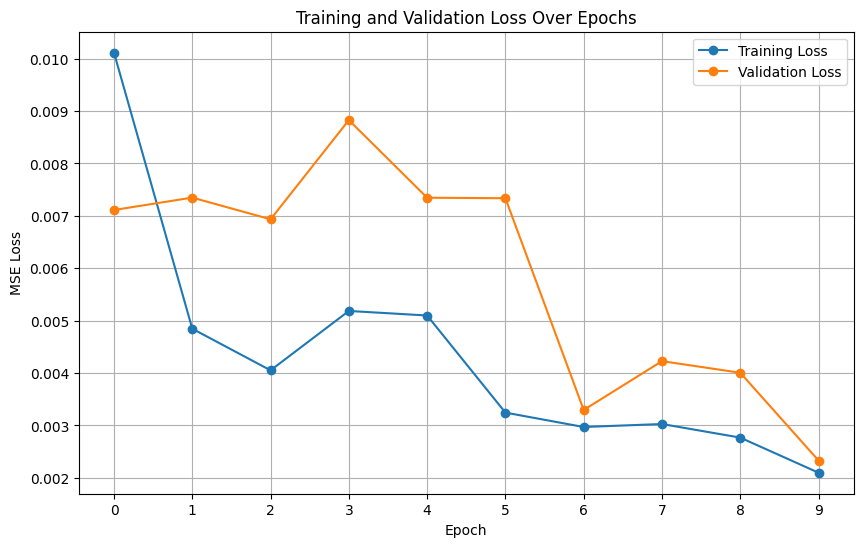

In [15]:
# Plot training and validation losses
# val_losses = [val_loss]  # Since validation is run once after training, use the last val_loss

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.xticks(range(epochs))
plt.show()

Validating: 100%|██████████| 125/125 [00:08<00:00, 14.86it/s]


Validation Loss: 0.0023
Validation MAE: 0.8189 kW, RMSE: 1.3733 kW


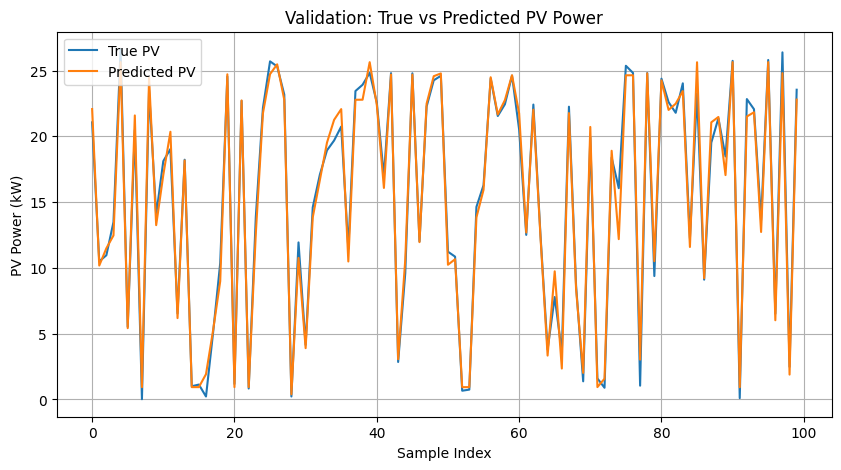

In [16]:
# If scaler is not in scope, you need to load it or redefine it; for now, assume it's from Cell 3
global scaler  # Declare as global if needed, or pass it explicitly

# Validation cell to evaluate model performance on test data
def validate_model(model, test_loader, criterion, device, scaler):
    model.eval()
    val_loss = 0.0
    predictions = []
    true_values = []

    with torch.no_grad():
        for img_seq, pv_seq, target in tqdm(test_loader, desc="Validating"):
            img_seq, pv_seq, target = img_seq.to(device), pv_seq.to(device), target.to(device)

            output = model(img_seq, pv_seq)
            loss = criterion(output, target)
            val_loss += loss.item()

            predictions.extend(output.cpu().numpy())
            true_values.extend(target.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    return avg_val_loss, np.array(predictions), np.array(true_values)

# Run validation (pass the scaler from Cell 3)
# Assuming scaler is available from the global scope (defined in Cell 3)
from sklearn.preprocessing import MinMaxScaler

# Run validation
val_loss, predictions, true_values = validate_model(model, test_loader, criterion, device, scaler)
print(f"Validation Loss: {val_loss:.4f}")

# Denormalize predictions and true values for meaningful metrics
true_values_denorm = scaler.inverse_transform(true_values.reshape(-1, 1)).squeeze()
predictions_denorm = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze()

# Calculate metrics (MAE and RMSE as per paper's abbreviations)
mae = np.mean(np.abs(predictions_denorm - true_values_denorm))
rmse = np.sqrt(np.mean((predictions_denorm - true_values_denorm) ** 2))
print(f"Validation MAE: {mae:.4f} kW, RMSE: {rmse:.4f} kW")

# Calculate accuracy (percentage of predictions within 10% error)
threshold = 0.10  # 10% error threshold
abs_percentage_error = np.abs((predictions_denorm - true_values_denorm) / true_values_denorm) * 100

# Plot validation results
plt.figure(figsize=(10, 5))
plt.plot(true_values_denorm[:100], label='True PV')
plt.plot(predictions_denorm[:100], label='Predicted PV')
plt.xlabel('Sample Index')
plt.ylabel('PV Power (kW)')
plt.title('Validation: True vs Predicted PV Power')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
print(val_losses)

[0.007111573935486376, 0.0073483233521692455, 0.006934186885133386, 0.008827209033071996, 0.0073460674788802865, 0.007336123251356184, 0.003294428214430809, 0.004226742197293788, 0.004005113385617733, 0.002329745062859729]


## Inference

In [18]:
import torch
import joblib
import numpy as np

# Reload model
model = SunsetForecast()  # replace with your model class
model.load_state_dict(torch.load("saved_model.pth", map_location=device))
model.to(device)
model.eval()

# Reload scaler
scaler = joblib.load("scaler.pkl")

# Reload losses
loss_data = np.load("losses.npz")
train_losses = loss_data["train_losses"].tolist()
val_losses = loss_data["val_losses"].tolist()

print("✅ Model, scaler, and losses reloaded successfully.")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model, scaler, and losses reloaded successfully.



--- Inference Sample (idx=100) ---


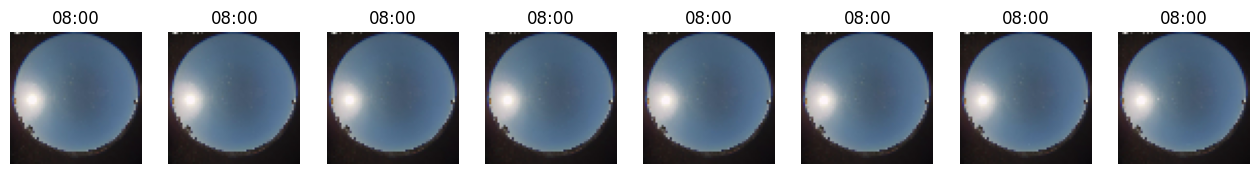

                     Time        PV
2017-03-09 08:27:00-08:00  9.756227
2017-03-09 08:28:00-08:00  9.883687
2017-03-09 08:29:00-08:00 10.006269
2017-03-09 08:30:00-08:00 10.095239
2017-03-09 08:31:00-08:00 10.220057
2017-03-09 08:32:00-08:00 10.342463
2017-03-09 08:33:00-08:00 10.375571
2017-03-09 08:34:00-08:00 10.587280

🔹 Prediction Results:
Target Time: 2017-03-09 08:36:00-08:00
Predicted PV (t+15): 10.79
True PV (t+15): 10.77


In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Parameters
seq_len = 8
horizon = 15
idx = 100  # sample index

start = idx
end = idx + seq_len
target_idx = idx + seq_len + 1

if target_idx >= len(pv_norm):
    raise ValueError("Index too close to dataset end.")

print(f"\n--- Inference Sample (idx={idx}) ---")

# 1️⃣ Show input image sequence
fig, axes = plt.subplots(1, seq_len, figsize=(16, 3))
for t in range(seq_len):
    axes[t].imshow(images[start + t])
    axes[t].axis("off")
    axes[t].set_title(f"{times[start + t][-5:]}")
plt.show()

# 2️⃣ PV history (unnormalized only)
pv_hist_norm = pv_norm[start:end]
pv_hist_raw = scaler.inverse_transform(pv_hist_norm.reshape(-1, 1)).flatten()

df = pd.DataFrame({
    "Time": times[start:end],
    "PV": pv_hist_raw  # actual values
})
print(df.to_string(index=False))

# 3️⃣ Prepare model inputs
img_seq = torch.tensor(images[start:end]).permute(0, 3, 1, 2).unsqueeze(0)  # (1, seq_len, 3, 64, 64)
pv_seq = torch.tensor(pv_hist_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # (1, seq_len, 1)

img_seq, pv_seq = img_seq.to(device), pv_seq.to(device)

# 4️⃣ Run inference
with torch.no_grad():
    pred_norm = model(img_seq, pv_seq).cpu().numpy().squeeze()

# 5️⃣ Unnormalize prediction + true target
pred_pv = scaler.inverse_transform(pred_norm.reshape(-1, 1)).item()
true_pv = scaler.inverse_transform(pv_norm[target_idx].reshape(-1, 1)).item()

print(f"\n🔹 Prediction Results:")
print(f"Target Time: {times[target_idx]}")
print(f"Predicted PV (t+{horizon}): {pred_pv:.2f}")
print(f"True PV (t+{horizon}): {true_pv:.2f}")


## Metrics

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_multistep_full(model, images, pv_norm, times, scaler, device,
                            start_idx=100, seq_len=8, max_horizon=15):
    """
    Multi-step evaluation (steps 9 → 15) with full metrics:
    RMSE, MAE, MBE, R², nRMSE, FS.
    """
    model.eval()
    start = start_idx
    end = start + seq_len

    pv_hist_norm = pv_norm[start:end].tolist()
    img_hist = images[start:end]

    preds, trues, spm_preds, future_times = [], [], [], []

    # Autoregressive prediction loop
    for step in range(seq_len+1, max_horizon+1):
        target_idx = start_idx + step
        if target_idx >= len(pv_norm):
            break

        img_seq = torch.tensor(img_hist).permute(0, 3, 1, 2).unsqueeze(0).to(device)
        pv_seq = torch.tensor(pv_hist_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)

        with torch.no_grad():
            pred_norm = model(img_seq, pv_seq).cpu().numpy().squeeze()

        pred = scaler.inverse_transform(pred_norm.reshape(-1, 1)).item()
        true = scaler.inverse_transform(pv_norm[target_idx].reshape(-1, 1)).item()
        spm_pred = scaler.inverse_transform(np.array(pv_hist_norm[-1]).reshape(-1, 1)).item()

        preds.append(pred)
        trues.append(true)
        spm_preds.append(spm_pred)
        future_times.append(times[target_idx])

        pv_hist_norm.append(pred_norm)
        pv_hist_norm = pv_hist_norm[-seq_len:]
        img_hist = images[target_idx-seq_len+1:target_idx+1]

    preds, trues, spm_preds = np.array(preds), np.array(trues), np.array(spm_preds)

    # Metrics
    rmse = np.sqrt(mean_squared_error(trues, preds))
    mae = mean_absolute_error(trues, preds)
    mbe = np.mean(trues - preds)
    r2 = r2_score(trues, preds)
    nrmse = rmse / np.mean(trues)
    rmse_spm = np.sqrt(mean_squared_error(trues, spm_preds))
    fs = (rmse_spm - rmse) / rmse_spm if rmse_spm > 0 else None

    # Print results
    print("📊 Multi-step Evaluation (Steps 9 → 15)")
    for t, p, g, spm in zip(future_times, preds, trues, spm_preds):
        print(f"Time: {t}, Predicted PV: {p:.2f}, True PV: {g:.2f}, SPM: {spm:.2f}")

    print("\n🔹 Metrics")
    print(f"RMSE:   {rmse:.4f}")
    print(f"MAE:    {mae:.4f}")
    print(f"MBE:    {mbe:.4f}")
    print(f"R²:     {r2:.4f}")
    print(f"nRMSE:  {nrmse:.4f}")
    print(f"FS:     {fs:.4f} (vs SPM)")

    return preds, trues, spm_preds, {"RMSE": rmse, "MAE": mae, "MBE": mbe, "R²": r2, "nRMSE": nrmse, "FS": fs}

# 🔥 Call the model
preds, trues, spm_preds, metrics = evaluate_multistep_full(
    model, images, pv_norm, times, scaler, device,
    start_idx=100, seq_len=8, max_horizon=15
)


📊 Multi-step Evaluation (Steps 9 → 15)
Time: 2017-03-09 08:36:00-08:00, Predicted PV: 10.79, True PV: 10.77, SPM: 10.59
Time: 2017-03-09 08:37:00-08:00, Predicted PV: 11.01, True PV: 10.89, SPM: 10.79
Time: 2017-03-09 08:38:00-08:00, Predicted PV: 11.17, True PV: 11.04, SPM: 11.01
Time: 2017-03-09 08:39:00-08:00, Predicted PV: 11.37, True PV: 11.09, SPM: 11.17
Time: 2017-03-09 08:40:00-08:00, Predicted PV: 11.54, True PV: 11.25, SPM: 11.37
Time: 2017-03-09 08:41:00-08:00, Predicted PV: 11.63, True PV: 11.35, SPM: 11.54
Time: 2017-03-09 08:41:30-08:00, Predicted PV: 11.70, True PV: 11.41, SPM: 11.63

🔹 Metrics
RMSE:   0.2236
MAE:    0.2000
MBE:    -0.2000
R²:     -0.0375
nRMSE:  0.0201
FS:     -0.5487 (vs SPM)
